# Deployment: fastai2 demo with Amazon SageMaker

The following is a demo of deploying a fastai2 based model to Amazon SageMaker for deployment. Amazon SageMaker is a fully managed service that provides every developer and data scientist with the ability to build, train, and deploy machine learning (ML) models quickly. SageMaker removes the heavy lifting from each step of the machine learning process to make it easier to develop high quality models.

In the demo we will show how to 1) train a model locally with a SageMaker notebook instance 2) export our model and upload the model artefacts to S3 3) deploy the model locally to the same notebook instance to test and 4) deploy the endpoint to Amazon SageMaker to be deployed in a production setting.

The demo was run and tested by deploying an SageMaker Notebook instance as per the instructions outlined [here](https://forums.fast.ai/t/platform-amazon-sagemaker-aws/66020).

## Train the fastai model locally

First we will train our fastai model on the notebook instance using the kernel named `fastai2`.

In [2]:
from fastai2.vision.all import *
path = untar_data(URLs.PETS)/'images'

# create the image data loader
dls = ImageDataLoaders.from_path_re(path, get_image_files(path), pat=r'(.+)_\d+.jpg$', 
                                    item_tfms=RandomResizedCrop(460, min_scale=0.75), bs=64,
                                    batch_tfms=[*aug_transforms(size=299, max_warp=0),
                                    Normalize.from_stats(*imagenet_stats)])
# create the learner
learn = cnn_learner(dls, resnet34, metrics=error_rate).to_fp16()
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.457120,0.292967,0.097429,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.387619,0.219248,0.068336,00:20


## Export the model and upload to S3

Now that we have trained our model we will export it using the learner method `export()` and upload the exported model to S3.

In [3]:
learn.export()

Now let's create a tarfile for our model.

In [4]:
import tarfile
with tarfile.open(path/'model.tar.gz', 'w:gz') as f:
    f.add(path/'export.pkl', arcname='model.pkl')

In [5]:
import sagemaker

role = sagemaker.get_execution_role()
sess = sagemaker.Session()

In [6]:
prefix = 'DEMO-fastai2-sagemaker-oxford-pets'

Now we will upload the model to the default S3 bucket for sagemaker.

In [7]:
model_location = sess.upload_data(str(path/'model.tar.gz'), key_prefix=prefix)
model_location

's3://sagemaker-eu-west-1-934676248949/DEMO-fastai2-sagemaker-oxford-pets/model.tar.gz'

## Script for model inference

SageMaker invokes the main function defined within your training script for training. When deploying your trained model to an endpoint, the `model_fn()` is called to determine how to load your trained model. The `model_fn()` along with a few other functions list below are called to enable predictions on SageMaker.

### [Predicting Functions](https://github.com/aws/sagemaker-pytorch-containers/blob/master/src/sagemaker_pytorch_container/serving.py)
* `model_fn(model_dir)` - loads your model.
* `input_fn(serialized_input_data, content_type)` - deserializes predictions to predict_fn.
* `output_fn(prediction_output, accept)` - serializes predictions from predict_fn.
* `predict_fn(input_data, model)` - calls a model on data deserialized in input_fn.

Here is the full code in a file `serve.py` showing implementations of the 4 key functions:

In [9]:
!pygmentize scripts/serve.py

# Copyright 2017-2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.

import logging
import json
import io
import os

from fastai2.vision.all import *

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

JSON_CONTENT_TYPE = 'application/json'
EXPORT_MODEL_NAME = 'model.pkl'

# loads the model into memory from disk and returns it
def model_fn(model_dir):
    logger.info('model_fn')
    path_model = Path(model_dir)
    logger.debug(f'Loading model from path: {str(path_model/EXPOR

## Deploy locally to test

Before deploying to Amazon SageMaker we want to verify that the endpoint is working properly. The Amazon SageMaker Python SDK allows us to deploy locally to the Notebook instance using Docker. We will create the model then specify the parameter `instance_type` to be `local` telling the SDK to deploy locally.

In [12]:
from sagemaker.pytorch import PyTorchModel

model = PyTorchModel(model_data=model_location,
                     role=role,
                     framework_version='1.4.0',
                     entry_point='serve.py', 
                     source_dir='scripts')

Now that we have created the model we will deploy locally to test. It may take a while to run the first time as we need to download a Docker image to our notebook instance.

In [13]:
predictor = model.deploy(initial_instance_count=1, instance_type='local')

Attaching to tmpt323606i_algo-1-rcblk_1
algo-1-rcblk_1  | Collecting fastai2
algo-1-rcblk_1  |   Downloading fastai2-0.0.13-py3-none-any.whl (179 kB)
     |████████████████████████████████| 179 kB 10.0 MB/s eta 0:00:01
algo-1-rcblk_1  | Collecting ipykernel
algo-1-rcblk_1  |   Downloading ipykernel-5.2.0-py3-none-any.whl (117 kB)
     |████████████████████████████████| 117 kB 26.9 MB/s eta 0:00:01
algo-1-rcblk_1  | Collecting matplotlib
algo-1-rcblk_1  |   Downloading matplotlib-3.2.1-cp36-cp36m-manylinux1_x86_64.whl (12.4 MB)
     |████████████████████████████████| 12.4 MB 40.4 MB/s eta 0:00:01
algo-1-rcblk_1  | Collecting fastprogress>=0.1.22
algo-1-rcblk_1  |   Downloading fastprogress-0.2.2-py3-none-any.whl (12 kB)
algo-1-rcblk_1  | Requirement already satisfied: scikit-learn in /opt/conda/lib/python3.6/site-packages (from fastai2->-r /opt/ml/model/code/requirements.txt (line 1)) (0.21.2)
algo-1-rcblk_1  | Requirement already satisfied: pillow in /opt/conda/lib/python3.6/site-packa

algo-1-rcblk_1  | Collecting pyzmq>=13
algo-1-rcblk_1  |   Downloading pyzmq-19.0.0-cp36-cp36m-manylinux1_x86_64.whl (1.1 MB)
     |████████████████████████████████| 1.1 MB 48.2 MB/s eta 0:00:01
algo-1-rcblk_1  | Collecting jupyter-core>=4.6.0
algo-1-rcblk_1  |   Downloading jupyter_core-4.6.3-py2.py3-none-any.whl (83 kB)
     |████████████████████████████████| 83 kB 3.5 MB/s  eta 0:00:01
algo-1-rcblk_1  | Collecting importlib-metadata>=0.20; python_version < "3.8"
algo-1-rcblk_1  |   Downloading importlib_metadata-1.5.0-py2.py3-none-any.whl (30 kB)
algo-1-rcblk_1  | Requirement already satisfied: wcwidth in /opt/conda/lib/python3.6/site-packages (from prompt-toolkit<2.1.0,>=2.0.0->ipython>=5.0.0->ipykernel->-r /opt/ml/model/code/requirements.txt (line 2)) (0.1.8)
algo-1-rcblk_1  | Requirement already satisfied: ptyprocess>=0.5 in /opt/conda/lib/python3.6/site-packages (from pexpect; sys_platform != "win32"->ipython>=5.0.0->ipykernel->-r /opt/ml/model/code/requirements.txt (line 2)) (0

algo-1-rcblk_1  | 2020-03-24 11:38:57,526 [INFO ] W-9002-model com.amazonaws.ml.mms.wlm.WorkerThread - Backend response time: 811
algo-1-rcblk_1  | 2020-03-24 11:38:57,526 [INFO ] W-9007-model com.amazonaws.ml.mms.wlm.WorkerThread - Backend response time: 812
algo-1-rcblk_1  | 2020-03-24 11:38:57,526 [INFO ] W-9000-model com.amazonaws.ml.mms.wlm.WorkerThread - Backend response time: 796
algo-1-rcblk_1  | 2020-03-24 11:38:57,539 [INFO ] W-9003-model com.amazonaws.ml.mms.wlm.WorkerThread - Backend response time: 824
algo-1-rcblk_1  | 2020-03-24 11:38:57,539 [INFO ] W-9004-model com.amazonaws.ml.mms.wlm.WorkerThread - Backend response time: 825
algo-1-rcblk_1  | 2020-03-24 11:38:57,540 [INFO ] W-9006-model com.amazonaws.ml.mms.wlm.WorkerThread - Backend response time: 826
algo-1-rcblk_1  | 2020-03-24 11:38:57,541 [INFO ] W-9005-model com.amazonaws.ml.mms.wlm.WorkerThread - Backend response time: 828
algo-1-rcblk_1  | 2020-03-24 11:38:57,558 [INFO ] W-9001-model com.amazonaws.ml.mms.wlm.Wo

Now we can test out our endpoint. We will download a cat images from the internet and save locally.

In [14]:
! [ -d tmp ] || mkdir tmp
! wget -q -O tmp/british-shorthair.jpg https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg

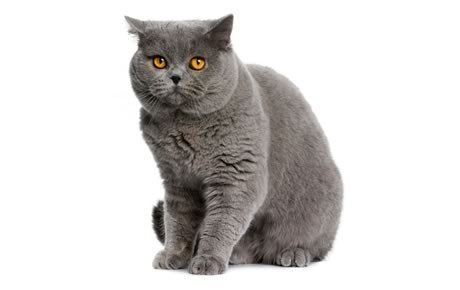

In [15]:
img = Image.open('tmp/british-shorthair.jpg')
img

Now we can call our local endpoint to ensure it is working and provides us the correct result.

In [16]:
from sagemaker.predictor import json_serializer, json_deserializer

predictor.accept = 'application/json'
predictor.content_type = 'application/json'

predictor.serializer = json_serializer
predictor.deserializer = json_deserializer

response = predictor.predict( { "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" })

print(response)

algo-1-rcblk_1  | 2020-03-24 11:39:16,128 [INFO ] W-9002-model-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - generated new fontManager
algo-1-rcblk_1  | 2020-03-24 11:39:16,914 [INFO ] W-9002-model-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - model_fn
algo-1-rcblk_1  | 2020-03-24 11:39:16,914 [INFO ] W-9002-model-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - Loading model from path: /opt/ml/model/model.pkl
algo-1-rcblk_1  | 2020-03-24 11:39:17,018 [INFO ] W-9002-model-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - model loaded successfully
algo-1-rcblk_1  | 2020-03-24 11:39:17,019 [INFO ] W-9002-model-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - Deserializing the input data.
algo-1-rcblk_1  | 2020-03-24 11:39:17,019 [INFO ] W-9002-model-stdout com.amazonaws.ml.mms.wlm.WorkerLifeCycle - Request body is: {"url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg"}
algo-1-rcblk_1  | 2020-03-24 11:39:17,019 [INFO ] W-90

Once you are happy that the endpoint is working suceessully you can shut it down.

In [17]:
predictor.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)


## Deploy to SageMaker

Once we have verified that the script is working successfully on our locally deployed endpoint we can deploy our model to Amazon SageMaker so that it can be used in a production application. The code is almost exactly the same as deploying locally except that when we call `model.deploy()` we will change the instance type to an Amazon SageMaker valid instance type (e.g. `ml.m5.xlarge`).

In [18]:
from sagemaker.pytorch import PyTorchModel

model = PyTorchModel(model_data=model_location,
                     role=role,
                     framework_version='1.4.0',
                     entry_point='serve.py', 
                     source_dir='scripts')

Now let's deploy our SageMaker endpoint. It will take a few min to provision.

In [19]:
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

-------------!

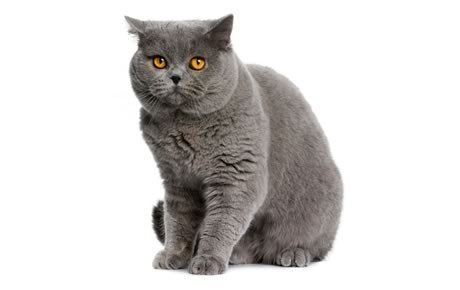

In [20]:
img = Image.open('tmp/british-shorthair.jpg')
img

Now let's test our remote endpoint running on SageMaker hosting services.

In [21]:
from sagemaker.predictor import json_serializer, json_deserializer

predictor.accept = 'application/json'
predictor.content_type = 'application/json'

predictor.serializer = json_serializer
predictor.deserializer = json_deserializer

response = predictor.predict( { "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" })

print(response)

{'class': 'British_Shorthair', 'confidence': 0.9974396228790283}


## Optional: delete endpoint

If you do not want to keep the endpoint up and running then remember to delete it to avoid incurring further costs.

In [22]:
predictor.delete_endpoint()